In [32]:
# install pyActigraphy using terminal
# pip3 install pyActigraphy

#### 1. Create function that will accept a file and run the set of pyAct functions on file
#### 2. Output a csv for each SPPD
#### 3. Input will be list of SPPD CSV files 
#### 4. Loop through files


In [33]:
#import sys
!{sys.executable} -m pip install plotly
#!{sys.executable} -m pip install pyActigraphy

^C


In [ ]:
# Import libraries
import pyActigraphy
from pyActigraphy.analysis import Fractal
from pyActigraphy.analysis import SSA
from pyActigraphy.analysis import Cosinor
import plotly.graph_objects as go
import os
import glob
import pandas as pd
import numpy as np

In [ ]:
# Main data path
dataPATH = 'D:\\Dropbox\\Publications_Meta\\InProgress\\ABaumgartner_Percept2020\\ACTrawPy\\'
savePATH = 'D:\\Dropbox\\Publications_Meta\\InProgress\\ABaumgartner_Percept2020\\ActPyOUT\\'

In [ ]:
# Create list of .csv files
os.chdir(dataPATH)
print(os.getcwd())
#print(os.listdir())
extension = 'csv'
csvFILES = glob.glob('*.{}'.format(extension))
print(csvFILES)

D:\Dropbox\Publications_Meta\InProgress\ABaumgartner_Percept2020\ACTrawPy
['SPPD_1.csv', 'SPPD_10.csv', 'SPPD_11.csv', 'SPPD_12.csv', 'SPPD_13.csv', 'SPPD_2.csv', 'SPPD_3.csv', 'SPPD_4.csv', 'SPPD_5.csv', 'SPPD_6.csv', 'SPPD_7.csv', 'SPPD_8.csv', 'SPPD_9.csv']


In [ ]:
# Loop through CSV files 
for FILE in csvFILES:
    #tmpfile = dataPATH + FILE
    tmpDF = runPYact(dataPATH , FILE , False , savePATH)
    # Name file save name based on case
    caseName = FILE.replace('.csv','') + '_ACT.csv'
    print(caseName)
    # export csv file
    saveLOCt = savePATH + caseName
    #tmpDF.to_excel(saveLOCt) 
    tmpDF.to_csv(saveLOCt)
    

In [ ]:
# Loop through CSV files 
for FILE in csvFILES:
    #tmpfile = dataPATH + FILE
    tmpDF , tmpCos = runPYactDAT(dataPATH , FILE , False , savePATH)
    # Name file save name based on case
    caseName1 = FILE.replace('.csv','') + '_actFit.csv'
    caseName2 = FILE.replace('.csv','') + '_CosinrParms.csv'
    print(caseName1)
    # export csv file
    saveLOCt1 = savePATH + caseName1
    saveLOCt2 = savePATH + caseName2
    #tmpDF.to_excel(saveLOCt) 
    tmpDF.to_csv(saveLOCt1)
    tmpCos.to_csv(saveLOCt2)


In [ ]:
FILE = csvFILES[0]
rawDATA = pyActigraphy.io.read_raw_rpx(dataPATH + FILE)
rawDATA.data.fillna(0 , inplace=True);
#print(rawDATA.data)
#go.Figure(go.Scatter(x=rawDATA.data.index.astype(str),y=rawDATA.data))
cosinor = Cosinor()
cosinor.fit_initial_params['Period'].value = 2880
results = cosinor.fit(rawDATA, verbose=True)
#results.params.valuesdict()
#print(results)
# FRACTAL 
cos_fit = cosinor.best_fit(rawDATA, results.params)
frac_fit = Fractal.profile(rawDATA.data.values)

# SSA
mySSA = SSA(rawDATA.data,window_length='24h')
mySSA.fit()
SSA_fit = mySSA.X_tilde(0)

circad_fit = mySSA.X_tilde([1,2])
ultrid_fit = mySSA.X_tilde([3,4])
rec_fit = mySSA.reconstructed_signal([0,1,2,3,4,5,6])
print('done')

# Outputs
# Cosinor HighLevel

# combine Cosinar, SSA, Fractal SSA-recon
#dfOUT = pd.concat([cos_fit,frac_fit,SSA_fit,circad_fit, ultrid_fit, rec_fit],axis=1)
#dfOUT.columns = ["Cosinor", "Fractal", "SSA", "CirSSA","UltSSA","RecSSA"]


In [ ]:
coS1 = cos_fit;
frA1 = frac_fit;
ssA1 = SSA_fit;
ciR1 = circad_fit;
ult1 = ultrid_fit;
reC1 = rec_fit;

print(len(coS1))
print(len(frA1))
print(len(ssA1))
print(len(ciR1))
print(len(ult1))
print(len(reC1))

cos2 = pd.DataFrame(coS1, columns = ['Cosine'])
fra2 = pd.DataFrame(frA1, columns = ['Fractal'])
ssa2 = pd.DataFrame(ssA1, columns = ['SSA'])
ciR2 = pd.DataFrame(ciR1, columns = ['Circadian'])
ult2 = pd.DataFrame(ult1, columns = ['Ultridian'])
reC2 = pd.DataFrame(reC1, columns = ['Reconstruct'])

fra2.index = cos2.index;
ssa2.index = cos2.index;
ciR2.index = cos2.index;
ult2.index = cos2.index;
reC2.index = cos2.index;

dfOUT = pd.concat([cos2,fra2,ssa2,ciR2,ult2,reC2],axis= 1)




In [ ]:
def runPYact(dataPATH , rawFILE , plotFlag , savePATH):
    rawDATA = pyActigraphy.io.read_raw_rpx(dataPATH + rawFILE) # rawFILE is string and dataPATH is directory
    print(rawDATA)
    print(rawDATA.IS())
    # Collect 
    CK = rawDATA.CK() # Cole-Kripke Automatic Sleep/Wake Identification From Wrist Activity. 
    # Sleep, 15(5), 461–469. http://doi.org/10.1093/sleep/15.5.461
    sadeh = rawDATA.Sadeh() # Sadeh algorithm [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8472753/]
    scripps = rawDATA.Scripps() # Scripps clinic algorithm
    oakley = rawDATA.Oakley(threshold='automatic') # Algorithm used by Actiware Respirionics
    crespo = rawDATA.Crespo(estimate_zeta=True) # Crespo algorithm Automatic identification of 
    # activity–rest periods based on 
    # actigraphy. Medical & Biological Engineering & Computing, 50(4),
    # 329–340. http://doi.org/10.1007/s11517-012-0875-y

    # COSINAR

    

    aot = rawDATA.Crespo_AoT()
    timeIndexCrespo = aot[0]-aot[1]

    # roenneberg = rawDATA.Roenneberg() # Human Activity and Rest
    # In Situ. In Methods in Enzymology (Vol. 552, pp. 257-283).
    # http://doi.org/10.1016/bs.mie.2014.11.028
    roenneberg = rawDATA.Roenneberg(threshold=0.20, min_seed_period='15min')

    if plotFlag:
        layout = go.Layout(title="Rest/Activity detection",xaxis=dict(title="Date time"), yaxis=dict(title="Counts/period"), showlegend=False)
        layout.update(yaxis2=dict(title='Classification',overlaying='y',side='right'), showlegend=True);
        go.Figure(data=[go.Scatter(x=rawDATA.data.index.astype(str),y=rawDATA.data, name='Data'),
        go.Scatter(x=CK.index.astype(str),y=CK, yaxis='y2', name='CK'),
        go.Scatter(x=sadeh.index.astype(str),y=sadeh, yaxis='y2', name='Sadeh'),
        go.Scatter(x=scripps.index.astype(str),y=scripps, yaxis='y2', name='Scripps'),
        go.Scatter(x=oakley.index.astype(str),y=scripps, yaxis='y2', name='Oakley (thr: automatic)'),
        go.Scatter(x=crespo.index.astype(str),y=crespo_zeta, yaxis='y2', name='Crespo (Automatic)'),
        go.Scatter(x=roenneberg.index.astype(str),y=roenneberg, yaxis='y2', name='Roenneberg'),
        ], layout=layout)


    # Bundle up pd.series
    dfOUT = pd.concat([CK,sadeh,scripps,oakley, crespo, roenneberg],axis=1)
    dfOUT.columns = ["CK", "Sadeh",  "Scripps", "Oakley","Crespo","Roneenberg"] 

    return dfOUT







In [ ]:
def runPYactDAT(dataPATH , rawFILE , plotFlag , savePATH):
    rawDATA = pyActigraphy.io.read_raw_rpx(dataPATH + rawFILE) # rawFILE is string and dataPATH is directory
    rawDATA.data.fillna(0 , inplace=True);
    # COSINAR
    cosinor = Cosinor()
    cosinor.fit_initial_params['Period'].value = 2880
    results = cosinor.fit(rawDATA, verbose=True)
    results.params.valuesdict()
    results.aic
    results.redchi
    cos_fit = cosinor.best_fit(rawDATA, results.params)

    # FRACTAL 
    frac_fit = Fractal.profile(rawDATA.data.values)

    # SSA
    mySSA = SSA(rawDATA.data,window_length='24h')
    mySSA.fit()
    SSA_fit = mySSA.X_tilde(0)

    circad_fit = mySSA.X_tilde([1,2])
    ultrid_fit = mySSA.X_tilde([3,4])
    rec_fit = mySSA.reconstructed_signal([0,1,2,3,4,5,6])

    # Outputs
    # Cosinor HighLevel

    # combine Cosinar, SSA, Fractal SSA-recon
    coS1 = cos_fit;
    frA1 = frac_fit;
    ssA1 = SSA_fit;
    ciR1 = circad_fit;
    ult1 = ultrid_fit;
    reC1 = rec_fit;
    cos2 = pd.DataFrame(coS1, columns = ['Cosine'])
    fra2 = pd.DataFrame(frA1, columns = ['Fractal'])
    ssa2 = pd.DataFrame(ssA1, columns = ['SSA'])
    ciR2 = pd.DataFrame(ciR1, columns = ['Circadian'])
    ult2 = pd.DataFrame(ult1, columns = ['Ultridian'])
    reC2 = pd.DataFrame(reC1, columns = ['Reconstruct'])

    fra2.index = cos2.index;
    ssa2.index = cos2.index;
    ciR2.index = cos2.index;
    ult2.index = cos2.index;
    reC2.index = cos2.index;

    dfOUT = pd.concat([cos2,fra2,ssa2,ciR2,ult2,reC2],axis= 1)
    
    recDict = results.params.valuesdict()
    recFrame = pd.DataFrame([recDict])
    recFrame['AIC'] = results.aic
    recFrame['BIC'] = results.bic
    recFrame['RchiS'] = results.redchi 

    return dfOUT , recFrame

In [ ]:
#raw2 = pyActigraphy.io.read_raw_rpx(dataPATH+'SPPD_1.csv')
#print(raw2)
#raw2.IS()
#raw2.IS(freq='30min')
#CK = raw2.CK()
#CK.rename(columns={'Activity' : 'CK'})
#print(CK)
#sadeh = raw2.Sadeh()
#scripps = raw2.Scripps()
#oakley = raw2.Oakley(threshold=40)
#oakley_auto = raw2.Oakley(threshold='automatic')
#crespo_zeta = raw2.Crespo(estimate_zeta=True)
#aot = raw2.Crespo_AoT()
#roenneberg = raw2.Roenneberg()
#roenneberg_thr = raw2.Roenneberg(threshold=0.25, min_seed_period='15min')


In [ ]:
#df=pd.concat([CK,sadeh,scripps,oakley, crespo_zeta, roenneberg],axis=1)
#df.columns = ["CK", "Sadeh",  "Scripps", "Oakley","Crespo","Roneenberg"] 
#df.head(10)
#df.to_excel('C://Users//Admin//anaconda3//Lib//site-packages//pyActigraphy//tests//dataout.xlsx') 

In [42]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
import pandas as pd
import os
import glob
import pandas as pd
import numpy as np
# use pythonProject1

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


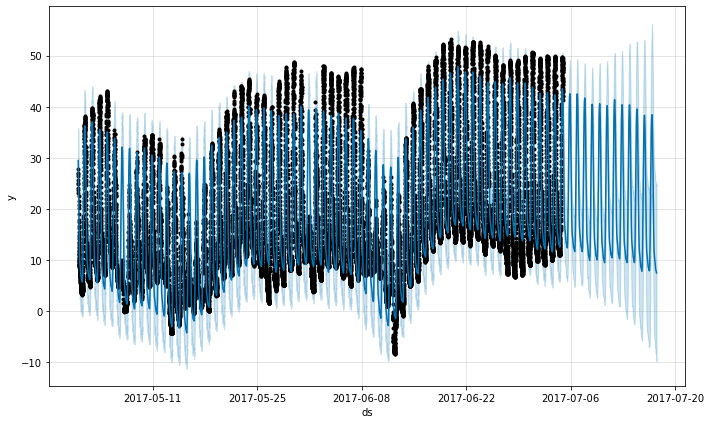

In [ ]:
df = pd.read_csv('C:\\Users\\John\\Downloads\\prophet-main\\prophet-main\\examples\\example_yosemite_temps.csv')
m = Prophet(changepoint_prior_scale=0.01).fit(df)
future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(future)
fig = m.plot(fcst)

In [ ]:
print(fcst)

                       ds      trend  yhat_lower  yhat_upper  trend_lower  \
0     2017-05-01 00:00:00  18.384890   22.921288   35.815259    18.384890   
1     2017-05-01 00:05:00  18.382223   22.807148   35.455162    18.382223   
2     2017-05-01 00:10:00  18.379556   21.826082   35.333175    18.379556   
3     2017-05-01 00:15:00  18.376889   22.131193   35.072946    18.376889   
4     2017-05-01 00:20:00  18.374222   21.028887   34.622998    18.374222   
...                   ...        ...         ...         ...          ...   
19016 2017-07-17 08:00:00  19.630050   -7.296582   25.559775     3.795090   
19017 2017-07-17 09:00:00  19.617240   -8.304893   25.474076     3.705837   
19018 2017-07-17 10:00:00  19.604430   -8.048091   24.910112     3.606481   
19019 2017-07-17 11:00:00  19.591620   -9.308050   24.536158     3.511395   
19020 2017-07-17 12:00:00  19.578810   -9.833635   25.003436     3.419969   

       trend_upper  additive_terms  additive_terms_lower  \
0        18.384

In [ ]:

#df_p = performance_metrics(fcst)
#df_p.head()

In [65]:
# Main data path
prodataPATH = 'D:\\Dropbox\\Publications_Meta\\InProgress\\ABaumgartner_Percept2020\\ActProphet\\raw\\'
prosavePATH = 'D:\\Dropbox\\Publications_Meta\\InProgress\\ABaumgartner_Percept2020\\ActProphet\\forcasT\\'

os.chdir(prodataPATH)
print(os.getcwd())
#print(os.listdir())
extension = 'csv'
ProcsvFILES = glob.glob('*.{}'.format(extension))

# Loop through CSV files 
for FILE in ProcsvFILES:
    #tmpfile = dataPATH + FILE
    tmpDF = runPyProhDAT(prodataPATH , FILE)
    # Name file save name based on case
    caseName = FILE.replace('.csv','') + '_FOR.csv'
    print(caseName)
    # export csv file
    savePLOCt = prosavePATH + caseName
    #tmpDF.to_excel(saveLOCt) 
    tmpDF.to_csv(savePLOCt)




#df = pd.read_csv('C:\\Users\\John\\Downloads\\prophet-main\\prophet-main\\examples\\example_yosemite_temps.csv')
#m = Prophet(changepoint_prior_scale=0.01).fit(df)
#future = m.make_future_dataframe(periods=300, freq='H')
#fcst = m.predict(future)

D:\Dropbox\Publications_Meta\InProgress\ABaumgartner_Percept2020\ActProphet\raw


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


SPPD10_R_Prophet_FOR.csv


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp

SPPD11_L_Prophet_FOR.csv


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp

SPPD11_R_Prophet_FOR.csv


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


SPPD12_L_Prophet_FOR.csv


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


SPPD12_R_Prophet_FOR.csv


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp

SPPD13_L_Prophet_FOR.csv


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp

SPPD13_R_Prophet_FOR.csv


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
c:\Users\John\Miniconda3\envs\pythonProject1\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp

SPPD9_R_Prophet_FOR.csv


In [49]:
def runPyProhDAT(dataPATH , rawFILE):
    tmpdf = pd.read_csv(dataPATH + rawFILE)
    mp = Prophet(changepoint_prior_scale=0.01).fit(tmpdf)
    futurep = mp.make_future_dataframe(periods=300, freq='H')
    fcstp = mp.predict(futurep)
    return fcstp
